# Algoritimos de Inteligência Artificial para clusterização

## Projeto da disciplina - Entrega final

### Aluno: Rafael Lima Paulo

#### Link para o github:

## Parte 1: Infraestrutura

### Instruções

Para criação do ambimente virtual execute os comandos a seguir:

* Criação do ambiente virtual com Anaconda:
`conda create -n cluster_env python=3.9`

* Ativação do ambiente:
`conda activate cluster_env`

* Instalação dos pacotes necessários:
`!pip install -r requirements.txt`


In [1]:
!pip install -r requirements.txt

## Parte 2: Base de dados

### Leitura e Análise da base de dados

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.neighbors import NearestNeighbors

import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline

In [43]:
# Carregar o dataset
df = pd.read_csv('Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


### Contagem dos países

In [44]:
num_countries = df['country'].nunique()
print(f"Número de países no dataset: {num_countries}")


Número de países no dataset: 167


### Análise Exploratória e Visualização das Variáveis

In [45]:
# Remover a coluna de países para facilitar a análise numérica
df_analysis = df.drop(columns=['country'])

# Estatísticas descritivas para observar a faixa das variáveis
df_analysis.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


### Análise de faixa dinâmica para clusterização

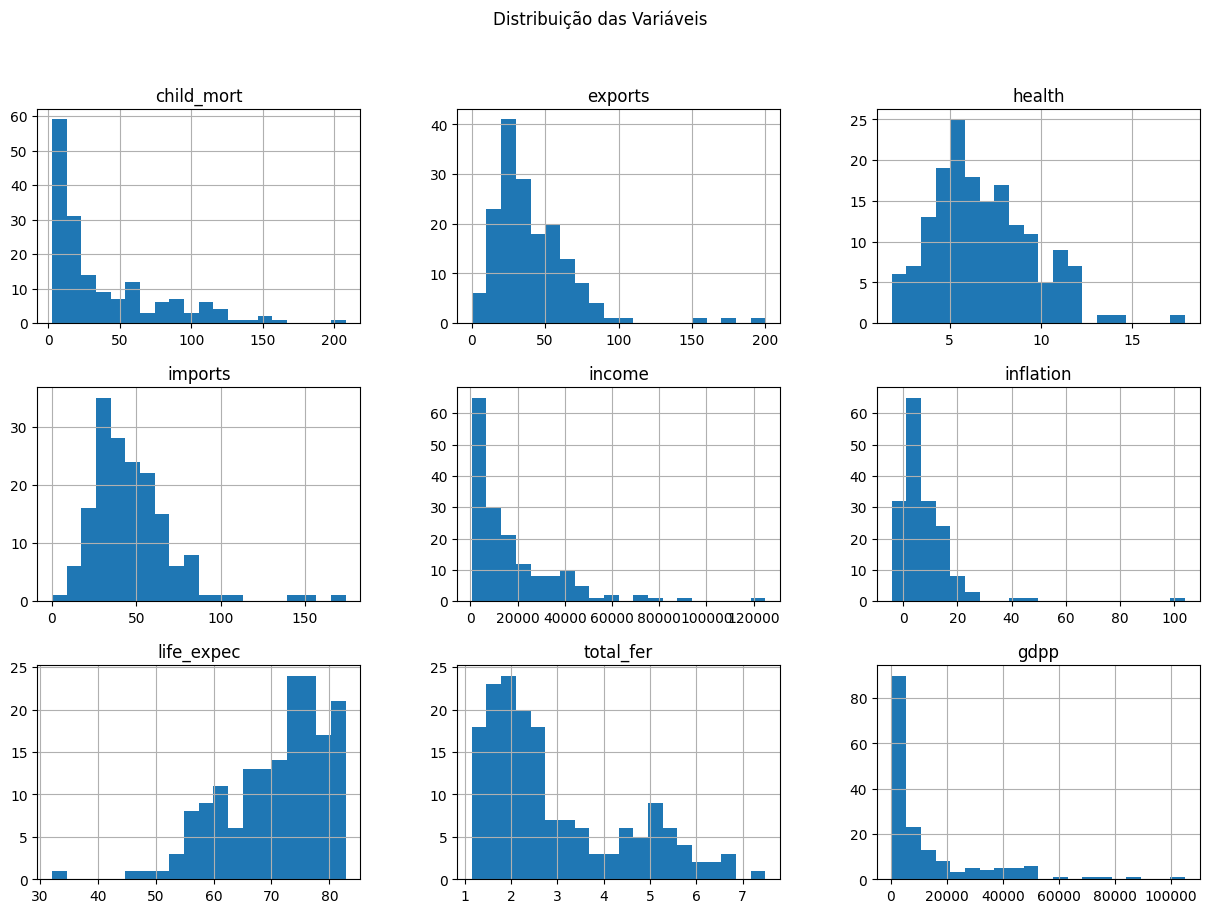

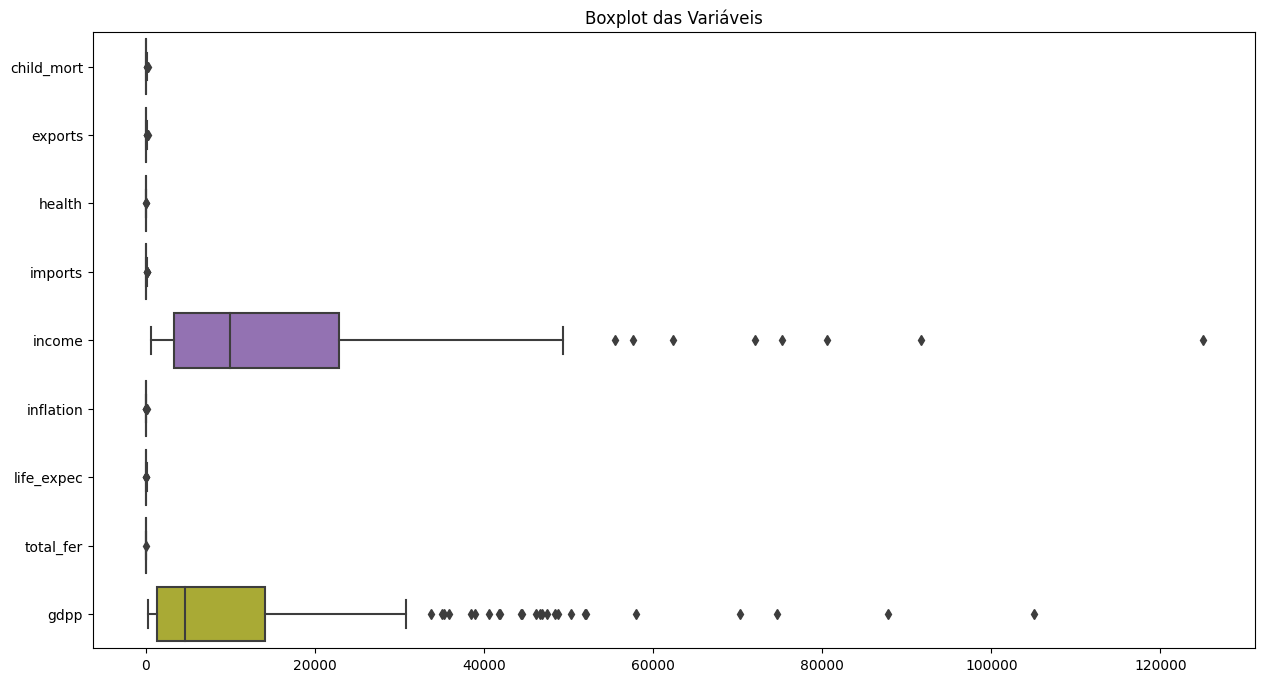

In [46]:
# Histogramas para verificar a distribuição de cada variável
df_analysis.hist(figsize=(15, 10), bins=20)
plt.suptitle('Distribuição das Variáveis')
plt.show()

# Boxplots para identificar outliers
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_analysis, orient="h")
plt.title('Boxplot das Variáveis')
plt.show()


#### Análise dos Resultados das Distribuições e Pré-Processamento

Observando os histogramas e boxplots das variáveis socioeconômicas e de saúde, podemos notar os seguintes pontos:

1. Distribuição Assimétrica e Outliers:
    *  A maioria das variáveis apresenta uma distribuição assimétrica, com caudas longas em direção aos valores mais altos (distribuição à direita). Por exemplo, variáveis como `income`, `gdpp` e `inflation` têm muitos valores concentrados em uma faixa menor, mas algumas observações distantes sugerem a presença de outliers.
    *  Os boxplots revelam outliers claros em variáveis como `income`, `gdpp` e `inflation`. Esses valores extremos podem distorcer as métricas de média e variância, o que afeta diretamente os métodos de clusterização que são sensíveis à escala e à distribuição dos dados.
2. Variáveis com Escalas Diferentes:
    * Algumas variáveis estão em escalas bastante diferentes (ex., `income` e `gdpp` estão em milhares, enquanto outras variáveis, como `life_expec` e `total_fer`, estão em uma escala muito menor). Isso torna essencial a aplicação de um escalonamento para padronizar os dados antes de aplicar algoritmos de clusterização, que podem ser influenciados por variáveis com maior magnitude.
3. Distribuições com Concentrações em Faixas Específicas:
    * Variáveis como `health`, `imports` e `exports` apresentam concentrações em faixas específicas, o que indica que muitos países têm valores semelhantes para essas características. Esse padrão pode influenciar o agrupamento, especialmente se um cluster representar países com características similares nessas variáveis.
  



### Pré-Processamento dos Dados

Para preparar os dados para a clusterização, tomaremos as seguintes ações:

* **Escalonamento:** Usaremos `StandardScaler` para padronizar as variáveis, de modo que cada uma tenha média zero e desvio padrão igual a um. Isso evita que variáveis com maiores valores numéricos dominem o processo de clusterização.

* **Tratamento de Outliers:** Dependendo dos resultados da clusterização, poderemos considerar a remoção ou transformação dos outliers para reduzir o impacto negativo que eles possam ter no agrupamento. Contudo, é recomendável realizar a clusterização inicialmente com todos os dados e, se necessário, repetir o processo após o tratamento de outliers.

Essas etapas de pré-processamento listadas acima, visam garantir que o algoritmo de clusterização possa identificar padrões baseados nas relações intrínsecas dos dados, sem ser influenciado por escalas ou valores extremos.

In [47]:
# Escalonamento das variáveis
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_analysis)

# Converte de volta para um DataFrame para manter a consistência nas etapas subsequentes
df_scaled = pd.DataFrame(df_scaled, columns=df_analysis.columns)
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817


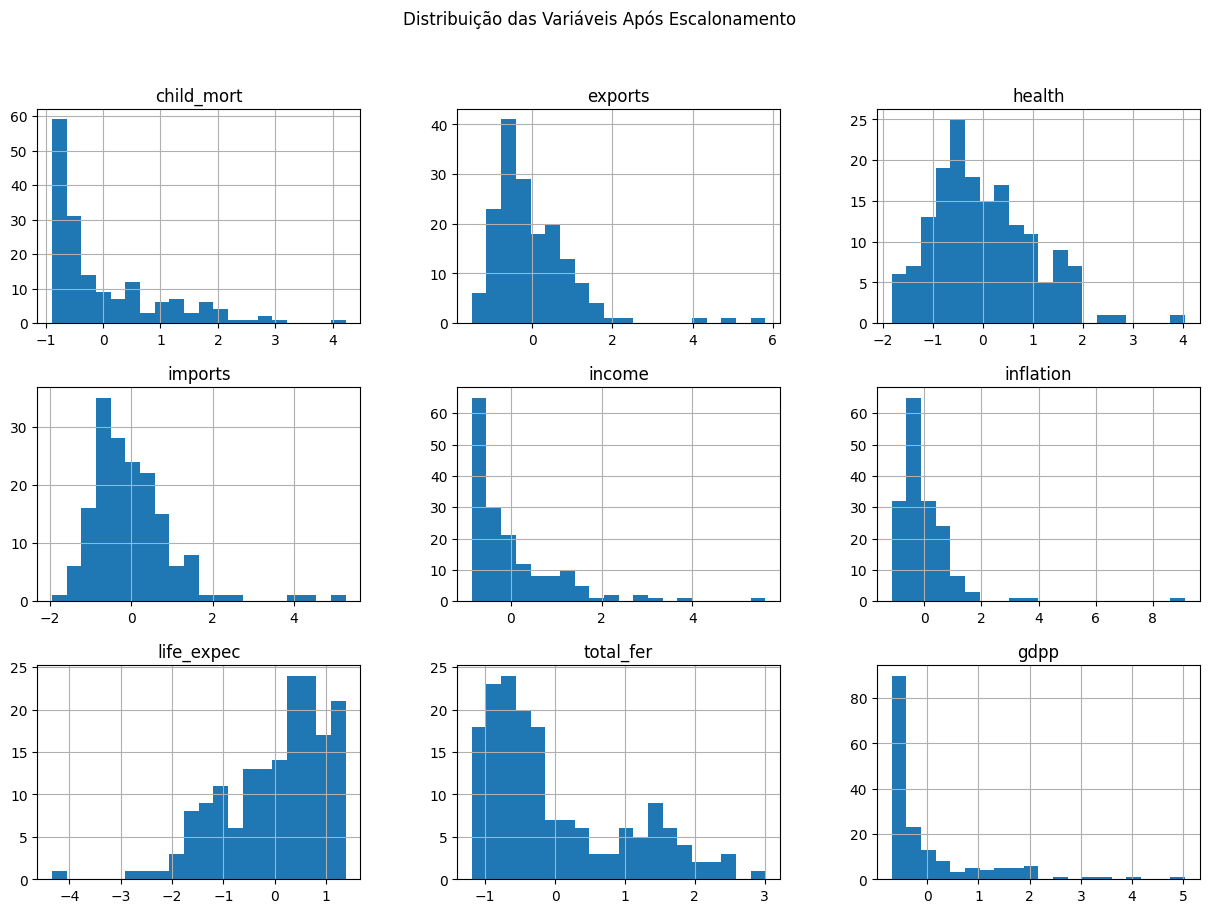

In [48]:
# Histograma das variáveis escalonadas
df_scaled.hist(figsize=(15, 10), bins=20)
plt.suptitle('Distribuição das Variáveis Após Escalonamento')
plt.show()

#### Análise do Histograma das Variáveis Após Escalonamento

* Observamos que, após o escalonamento, as distribuições das variáveis mantêm suas formas originais, mas agora estão em uma escala padronizada. Isso é esperado, pois o `StandardScaler` centraliza os dados em torno de uma média de zero e ajusta o desvio padrão para um, sem alterar a forma da distribuição.

* As variáveis ainda apresentam distribuições assimétricas, com caudas longas à direita em variáveis como `income`, `gdpp`, e `inflation`. Esse padrão pode indicar a presença de outliers ou uma distribuição desigual de características econômicas entre os países.

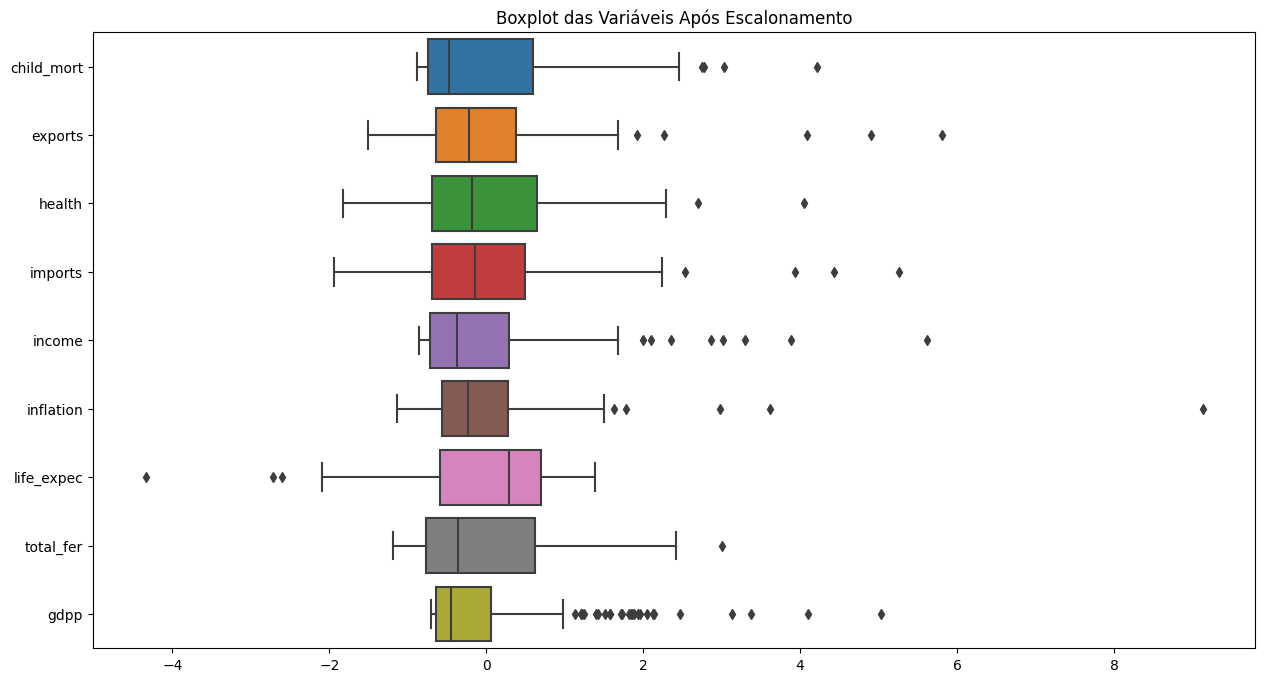

In [49]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_scaled, orient="h")
plt.title('Boxplot das Variáveis Após Escalonamento')
plt.show()

#### Análise do Boxplot das Variáveis Após Escalonamento:

* No boxplot das variáveis escalonadas, vemos que os outliers ainda estão presentes. No entanto, todas as variáveis agora possuem uma faixa semelhante (em torno de -3 a +3), o que facilita a comparação entre elas nos métodos de clusterização.

* A presença contínua de outliers sugere que esses pontos representam características genuínas dos dados (ou seja, países com valores extremos em determinadas métricas), o que pode ser relevante para a análise de clusterização. Esses países podem formar clusters próprios ou afetar a média de grupos maiores, dependendo do algoritmo utilizado.

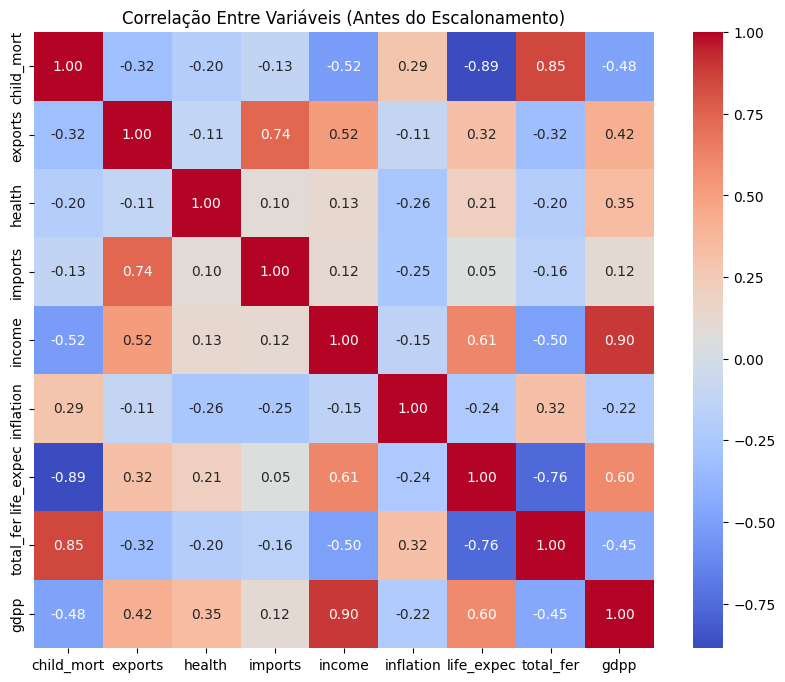

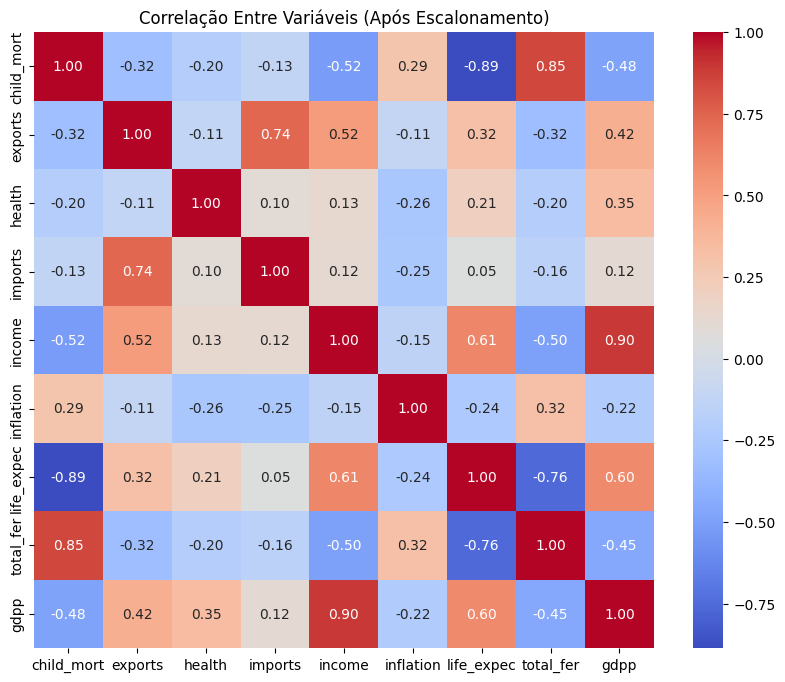

In [50]:
# Heatmap de correlação antes do escalonamento
plt.figure(figsize=(10, 8))
sns.heatmap(df_analysis.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlação Entre Variáveis (Antes do Escalonamento)')
plt.show()

# Heatmap de correlação depois do escalonamento
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(df_scaled, columns=df_analysis.columns).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlação Entre Variáveis (Após Escalonamento)')
plt.show()

#### Análise do Heatmap de Correlação Antes e Depois do Escalonamento:

* Ao comparar os heatmaps de correlação antes e depois do escalonamento, percebemos que as correlações entre variáveis permanecem inalteradas. Isso ocorre porque o escalonamento não altera as relações de correlação entre as variáveis, apenas transforma a escala dos valores.

* Notamos correlações fortes entre variáveis como `income` e `gdpp`, `life_expec` e `income`, entre outras. Essas correlações podem influenciar os agrupamentos, pois variáveis correlacionadas podem levar a redundância de informação. Considerando isso, poderíamos explorar técnicas como PCA (Principal Component Analysis) no futuro para reduzir a dimensionalidade, caso seja necessário.

### Considerações Finais Sobre o Pre-processamento:

A análise demonstra que o pré-processamento com escalonamento foi eficaz em padronizar as variáveis sem perder a forma original das distribuições. Esse processo é essencial para que o algoritmo de clusterização não seja influenciado desproporcionalmente por variáveis com valores iniciais maiores, como `income` e `gdpp`.

A presença de outliers ainda é evidente e deve ser monitorada durante a etapa de clusterização, pois esses pontos podem formar clusters isolados ou distorcer clusters maiores. No entanto, não realizamos nenhuma remoção de outliers nesta fase, pois esses valores extremos podem conter informações relevantes sobre as diferenças entre países.

## Parte 3: Clusterização

### Agrupamento dos países em 3 grupos distintos

#### K-Médias

In [59]:
# Definindo o número de clusters com n_init explícito para suprimir o warning
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_scaled['Cluster_KMeans'] = kmeans.fit_predict(df_scaled)

# Adicionando os rótulos de cluster ao DataFrame original para análise
df['Cluster_KMeans'] = df_scaled['Cluster_KMeans']

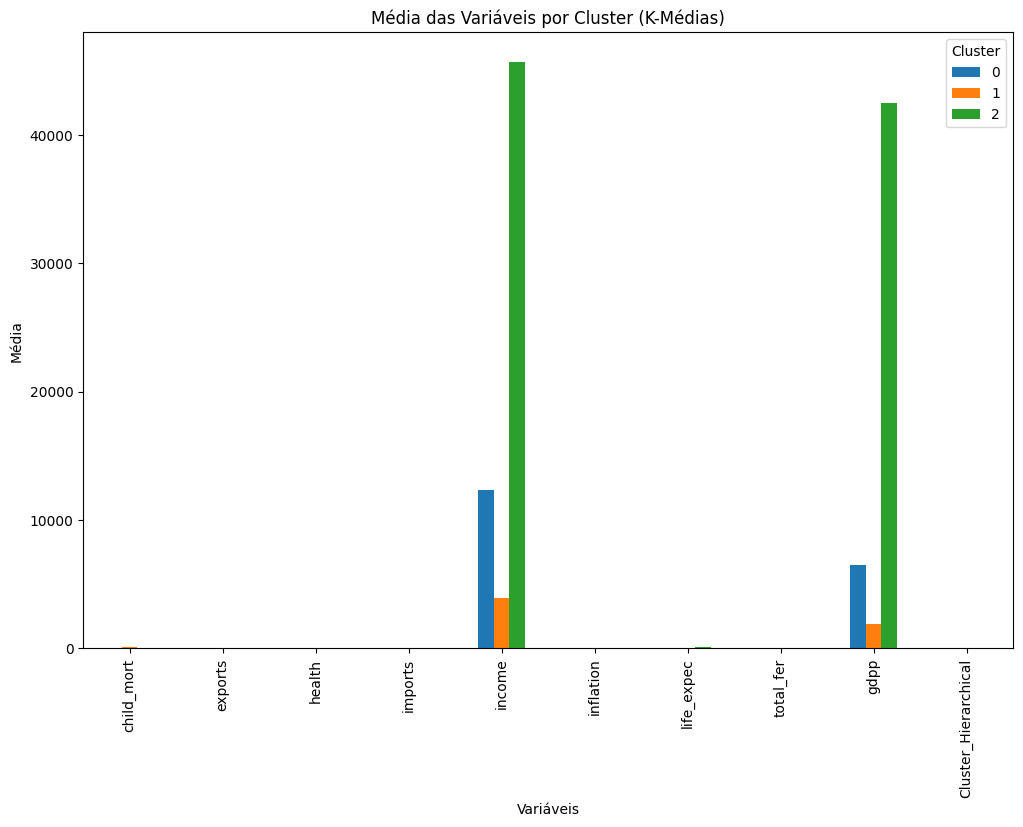

In [60]:
# Estatísticas descritivas por cluster
kmeans_summary = df.groupby('Cluster_KMeans').mean(numeric_only=True)

# Plotando a média das variáveis para cada cluster
kmeans_summary.T.plot(kind='bar', figsize=(12, 8))
plt.title('Média das Variáveis por Cluster (K-Médias)')
plt.xlabel('Variáveis')
plt.ylabel('Média')
plt.legend(title='Cluster')
plt.show()


Note que no gráfico acima há uma barra bem pequena para o `child_mort` e `life_expec`. Mais abaixo vamos modificar a escala para visualizar melhor. 

* **Cluster 0:** Este grupo apresenta valores intermediários para `income` e `gdpp`, além de taxas de `child_mort` e `life_expec` que são moderadas em comparação aos outros clusters, indicando países com um nível médio de desenvolvimento.
* **Cluster 1:** Possui os menores valores para `income` e `gdpp`, alta mortalidade infantil (`child_mort`) e baixa expectativa de vida (`life_expec`), sugerindo que esse grupo representa países em desenvolvimento ou com baixos índices de desenvolvimento.
* **Cluster 2:** É o cluster com os valores mais altos para `income` e `gdpp`, indicando que representa os países mais desenvolvidos economicamente. Esses países também têm alta expectativa de vida (`life_expec`) e baixa taxa de mortalidade infantil (`child_mort`), características típicas de países com alto desenvolvimento humano.


vamos tentar modificar a escala para visualizar melhor esses dados.

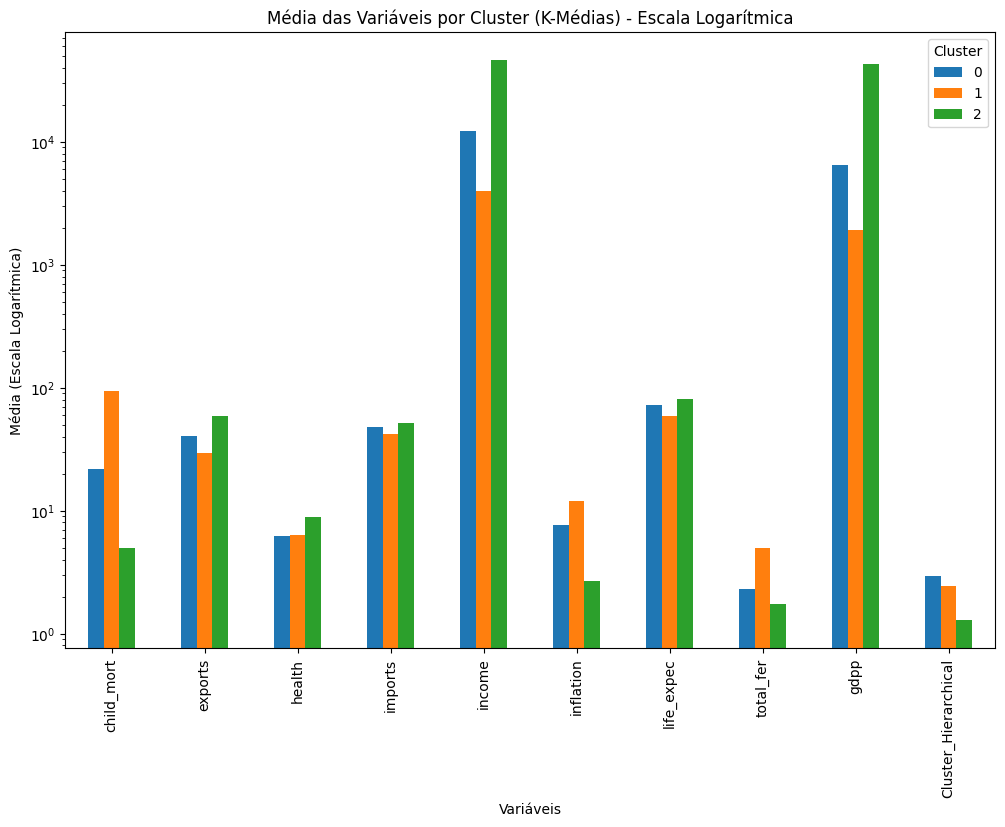

In [106]:
# Plotando as médias com escala logarítmica no eixo y
ax = kmeans_summary.T.plot(kind='bar', figsize=(12, 8))
plt.yscale('log')
plt.title('Média das Variáveis por Cluster (K-Médias) - Escala Logarítmica')
plt.xlabel('Variáveis')
plt.ylabel('Média (Escala Logarítmica)')
plt.legend(title='Cluster')
plt.show()


Neste gráfico, usamos uma escala logarítmica no eixo y, que torna as variáveis comparáveis, mesmo que algumas tenham valores muito maiores do que outras. Com essa escala podemos notar que:

* **Cluster 2** continua sendo o grupo com os maiores valores para income e gdpp, confirmando que representa os países com alto desenvolvimento econômico. A expectativa de vida (life_expec) também é mais alta neste grupo, e a mortalidade infantil (child_mort) é relativamente baixa.
* **Cluster 1** apresenta valores mais altos para child_mort e total_fer e menores para income e gdpp, sugerindo que esse cluster representa países menos desenvolvidos.
* **Cluster 0** aparece como intermediário em todas as variáveis, mostrando um perfil de países em desenvolvimento ou de desenvolvimento médio.

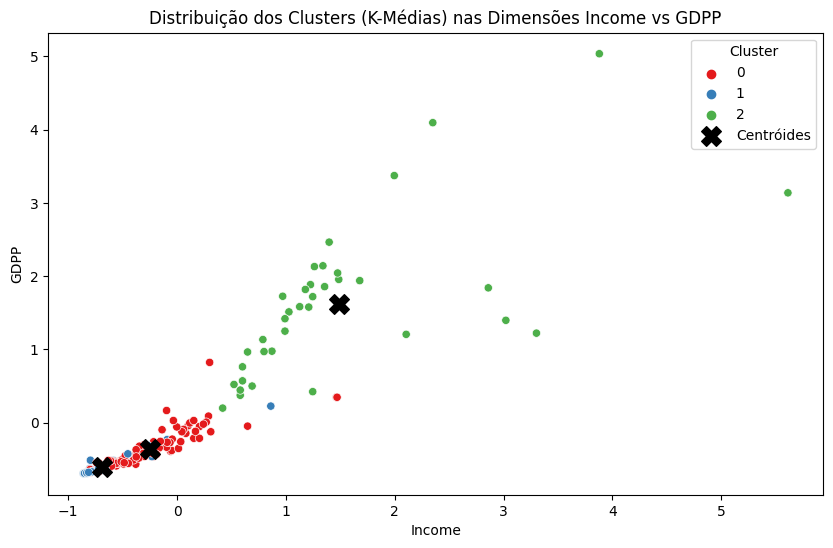

In [61]:
# Gráfico de dispersão das duas variáveis principais para os clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_scaled['income'], y=df_scaled['gdpp'], hue=df_scaled['Cluster_KMeans'], palette='Set1')
plt.scatter(kmeans.cluster_centers_[:, df_scaled.columns.get_loc('income')], 
            kmeans.cluster_centers_[:, df_scaled.columns.get_loc('gdpp')], 
            s=200, c='black', marker='X', label='Centróides')
plt.title('Distribuição dos Clusters (K-Médias) nas Dimensões Income vs GDPP')
plt.xlabel('Income')
plt.ylabel('GDPP')
plt.legend(title='Cluster')
plt.show()


No gráfico acima (dispersão das dimensões `income` vs `gdpp`), cada cluster está representado com os centróides indicados em preto. Podemos observar que:

1. **Distribuição dos Clusters:**
    * **Cluster 0 (Vermelho)** Poucos pontos se distanciam do Cluster 1, indicando que esses países têm uma leve elevação em `income` e `gdpp`, mas não o suficiente para serem considerados economicamente desenvolvidos. Eles são uma "transição" entre o Cluster 1 e o Cluster 2.
    * **Cluster 1 (Azul):** Países com menor `income` e `gdpp`, concentrados na parte inferior esquerda do gráfico. Esse grupo inclui países com baixo desenvolvimento econômico, pois ambas as variáveis econômicas estão em níveis baixos.
    * 
    * **Cluster 2 (Verde):** Esse cluster abrange países com `income` e `gdpp` significativamente mais altos, visíveis na parte superior direita do gráfico. Esses países representam economias mais avançadas.
2. **Posição dos Centróides:**
    * Os centróides em preto marcam o ponto médio de cada cluster em termos de `income` e `gdpp`. O centróide do Cluster 2 está claramente deslocado para valores mais altos em ambas as variáveis, indicando o grupo de países com economias mais robustas.
    * O centróide do Cluster 1 está na posição mais baixa, reforçando que esses países possuem características econômicas mais modestas.
    * O centróide do Cluster 0 está em uma posição intermediária, refletindo países com economia em desenvolvimento, mas sem os extremos de desenvolvimento do Cluster 2.
3. **Dispersão dentro dos Clusters:**
    * **Cluster 0** é mais compacto, o que sugere que os países nesse grupo têm variabilidade limitada nas dimensões `income` e `gdpp`.
    * **Cluster 2** é mais disperso, com países que variam em `gdpp` e `income` dentro do grupo, indicando maior diversidade econômica.
    * **Cluster 1** apresenta menor quantidade de pontos, sugerindo que poucos países ocupam essa faixa intermediária, sendo economicamente distintos dos extremos representados pelos Clusters 0 e 2.
      

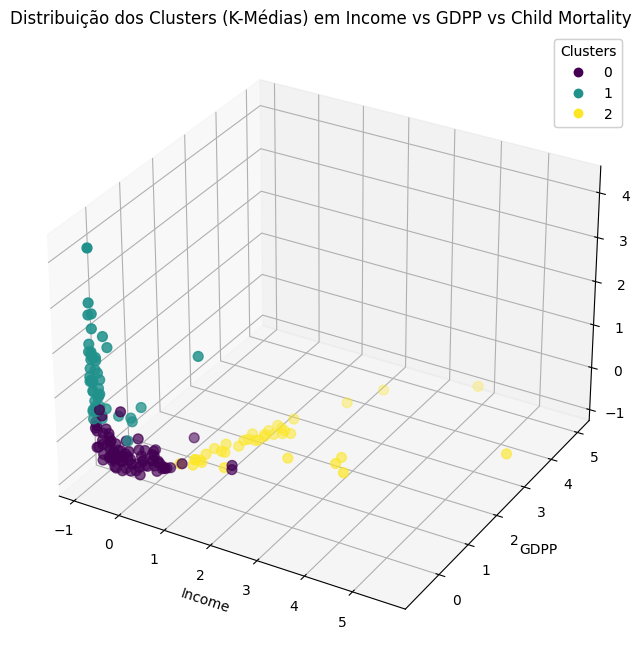

In [75]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersão 3D
scatter = ax.scatter(df_scaled['income'], df_scaled['gdpp'], df_scaled['child_mort'], 
                     c=df_scaled['Cluster_KMeans'], cmap='viridis', s=50)
ax.set_title('Distribuição dos Clusters (K-Médias) em Income vs GDPP vs Child Mortality')
ax.set_xlabel('Income')
ax.set_ylabel('GDPP')
ax.set_zlabel('Child Mortality')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()


Com base no gráfico acima (Distribuição dos Clusters em Income vs GDPP vs Child Mortality), podemos observar a distribuição das dimensões `Income`, `GDPP`, e `Child Mortality` para cada cluster gerado pelo algoritmo K-Means:

* **Cluster 0 (em roxo):** Esse grupo inclui países com baixa renda (`Income`) e baixo produto interno bruto (`GDPP`), mas apresenta uma maior taxa de mortalidade infantil (`Child Mortality`). Esses países tendem a ter menor desenvolvimento econômico e condições de saúde relativamente desfavoráveis.

* **Cluster 1 (em verde):** Esse cluster agrupa países com níveis moderados de `Income` e `GDPP`, além de uma taxa de `Child Mortality` intermediária. Esses países estão em uma faixa de desenvolvimento intermediária, com economias em crescimento e um nível de saúde que ainda apresenta desafios, mas é superior ao do Cluster 0.

* **Cluster 2 (em amarelo):** Esse grupo consiste em países com alta renda (`Income`) e alto `GDPP`, além de uma baixa taxa de `Child Mortality`. Representa países com um alto nível de desenvolvimento econômico e boas condições de saúde, indicando um ambiente socioeconômico mais favorável.

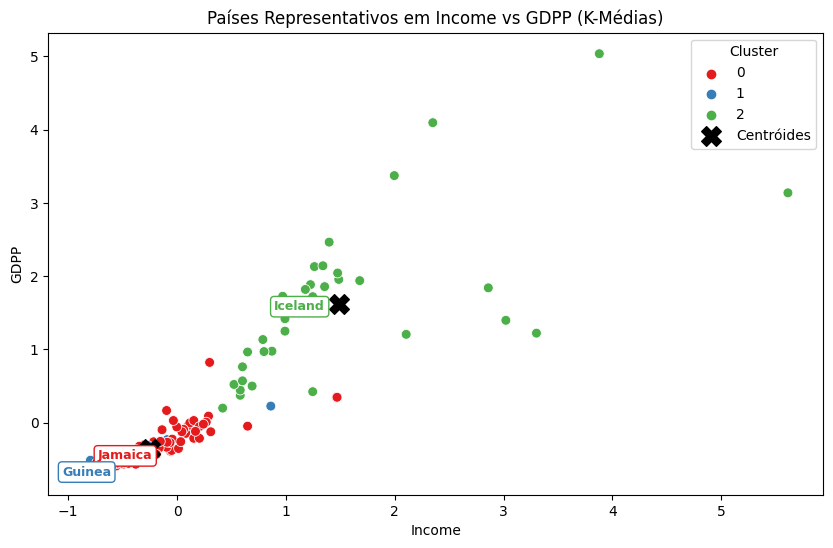

In [88]:
import numpy as np

# Garante que df_features e os centróides têm as mesmas colunas
centroid_columns = df_scaled.columns[df_scaled.columns.isin(variables)]  # Colunas de treino usadas no modelo
df_features = df_scaled[centroid_columns]

# Calcula a distância de cada ponto ao centróide do seu respectivo cluster
distances_to_centroid = []

for i, cluster_label in enumerate(df_scaled['Cluster_KMeans']):
    # Calcula a distância entre o ponto e o centróide do cluster ao qual ele pertence
    distance = np.linalg.norm(df_features.iloc[i].values - kmeans.cluster_centers_[cluster_label, :len(centroid_columns)])
    distances_to_centroid.append(distance)

# Adiciona as distâncias ao DataFrame
df_scaled['Distancia_Centroide'] = distances_to_centroid

# Identifica o país mais representativo (menor distância ao centróide) para cada cluster
representative_countries = df_scaled.loc[df_scaled.groupby('Cluster_KMeans')['Distancia_Centroide'].idxmin()]
representative_countries_names = df.loc[representative_countries.index, 'country']
representative_clusters = representative_countries['Cluster_KMeans'].values

# Mapeamento de cores para cada cluster
cluster_palette = sns.color_palette("Set1", n_colors=len(df_scaled['Cluster_KMeans'].unique()))
cluster_colors = {cluster: cluster_palette[i] for i, cluster in enumerate(sorted(df_scaled['Cluster_KMeans'].unique()))}

# Gráfico de dispersão com os países e destaque dos representativos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_scaled['income'], y=df_scaled['gdpp'], hue=df_scaled['Cluster_KMeans'], palette='Set1', s=50)

# Adicionar centróides ao gráfico
plt.scatter(kmeans.cluster_centers_[:, df_scaled.columns.get_loc('income')], 
            kmeans.cluster_centers_[:, df_scaled.columns.get_loc('gdpp')], 
            s=200, c='black', marker='X', label='Centróides')

# Destacar os países representativos de cada cluster com a cor do cluster
for idx, country, cluster in zip(representative_countries.index, representative_countries_names, representative_clusters):
    plt.text(df_scaled.loc[idx, 'income'], df_scaled.loc[idx, 'gdpp'], country, 
             fontsize=9, weight='bold', color=cluster_colors[cluster], ha='center', va='center', 
             bbox=dict(facecolor='white', edgecolor=cluster_colors[cluster], boxstyle='round,pad=0.3'))

plt.title('Países Representativos em Income vs GDPP (K-Médias)')
plt.xlabel('Income')
plt.ylabel('GDPP')
plt.legend(title='Cluster')
plt.show()


No gráfico de dispersão acima (Países Representativos em Income vs GDPP), podemos identificar os países mais próximos dos centróides de cada cluster, que são considerados os representantes de seus respectivos grupos:

* **Cluster 0:** Jamaica é o país representativo do Cluster 1, que abrange países com desenvolvimento intermediário. Jamaica apresenta níveis moderados de `Income e GDPP`, além de uma taxa de mortalidade infantil que é intermediária em comparação com os outros clusters.
 
* **Cluster 1:** Guinea é o país mais representativo desse cluster, que é caracterizado por baixo `Income` e `GDPP` e uma alta taxa de `Child Mortality`. Guinea se alinha bem com as características desse grupo de países com economias subdesenvolvidas e desafios de saúde.

* **Cluster 2:** Iceland é o país representativo desse cluster, caracterizado por altos níveis de `Income` e `GDPP``, além de uma baixa taxa de `Child Mortality`. Iceland exemplifica bem o grupo de países altamente desenvolvidos com boa qualidade de vida e sistemas de saúde eficientes.

#### Clusterização Hierárquica

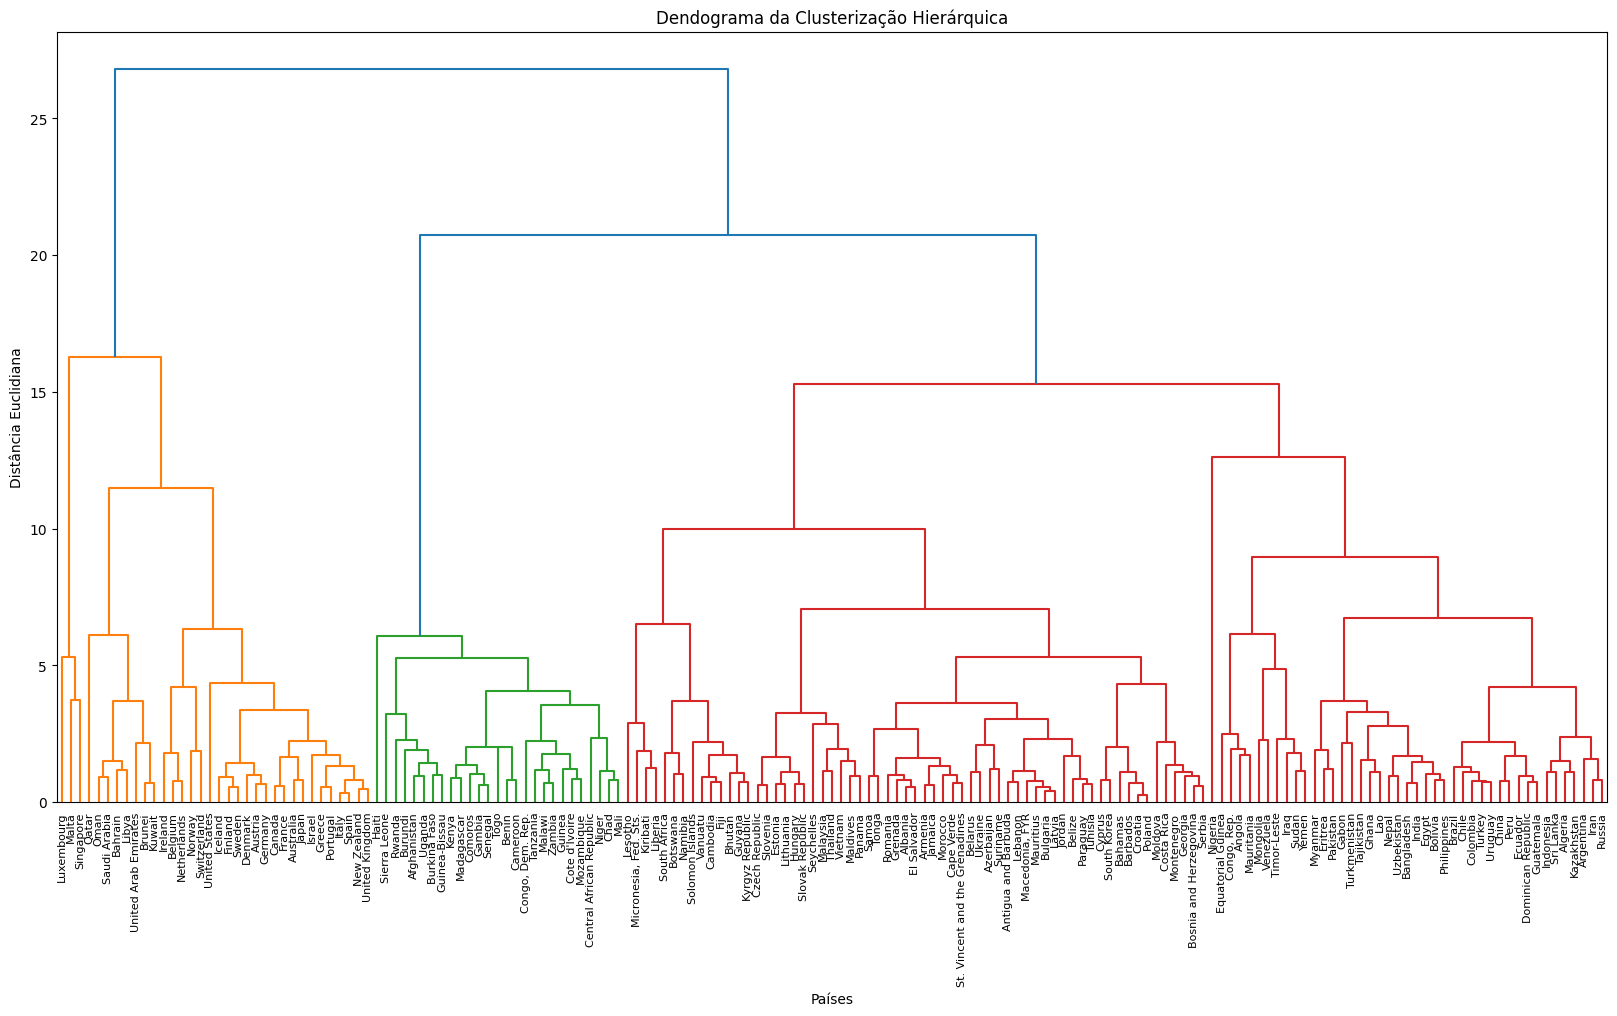

In [57]:
# Criando o linkage para a clusterização hierárquica
linkage_matrix = sch.linkage(df_scaled.drop(columns=['Cluster_KMeans'], errors='ignore'), method='ward')

# Plotando o dendograma
plt.figure(figsize=(20, 10))
sch.dendrogram(linkage_matrix, labels=df['country'].values, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendograma da Clusterização Hierárquica')
plt.xlabel('Países')
plt.ylabel('Distância Euclidiana')
plt.show()

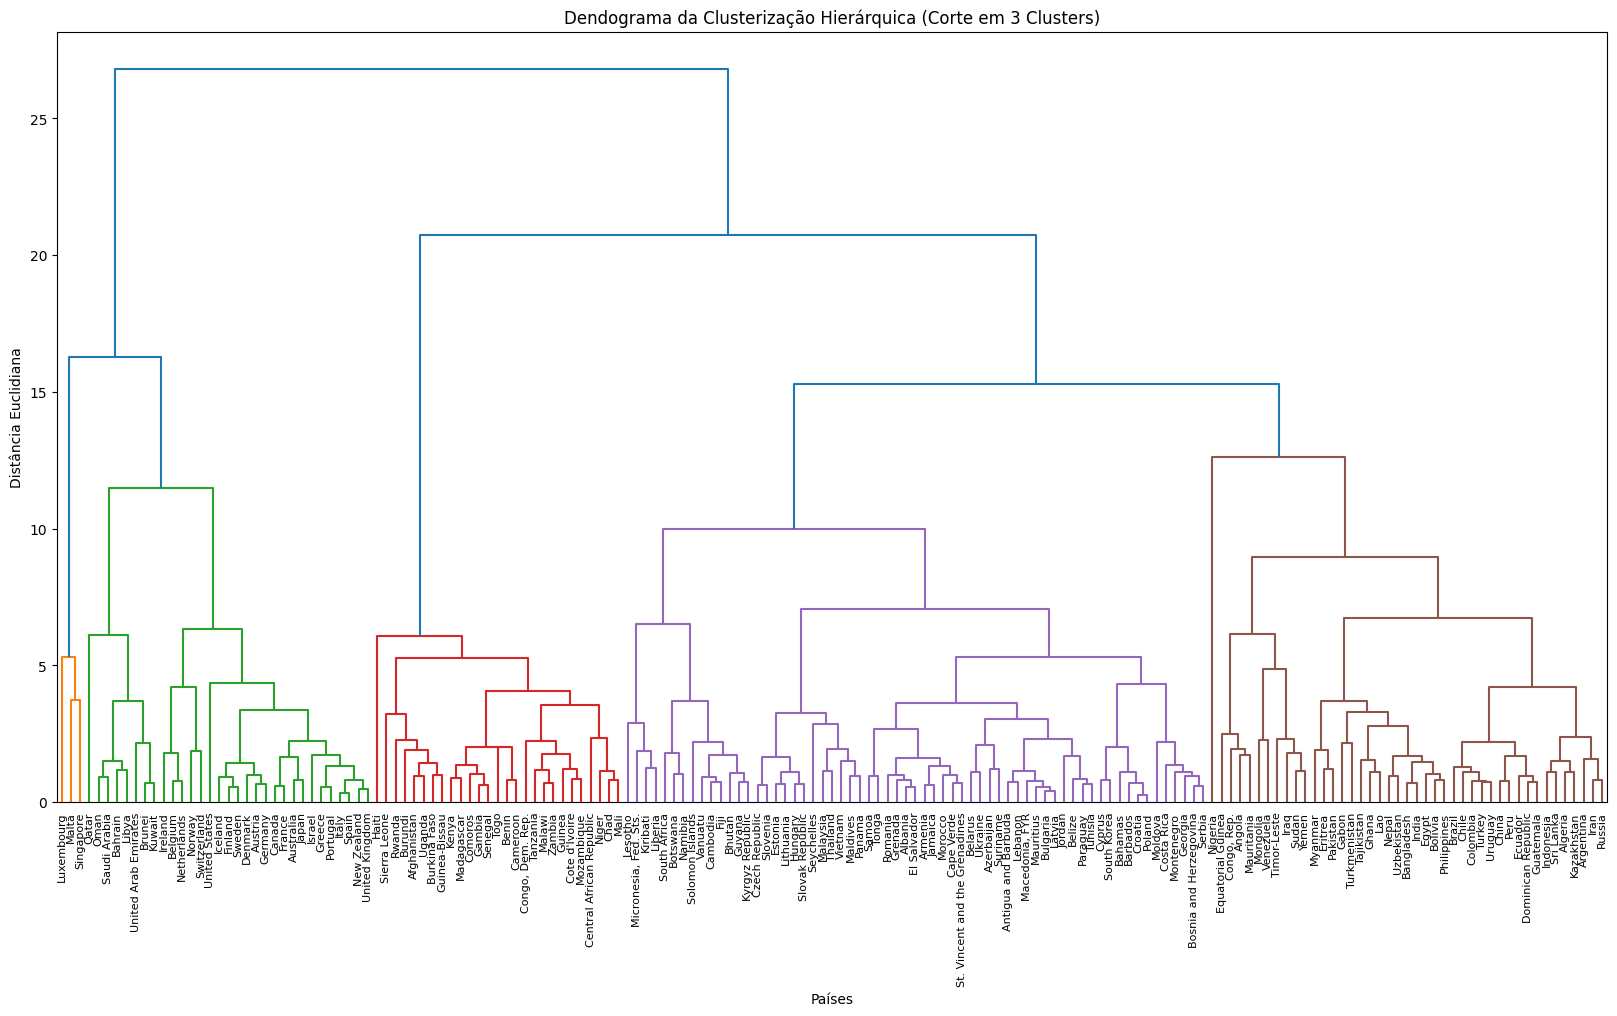

In [66]:
# Criando o dendograma com coloração nos 3 clusters
plt.figure(figsize=(20, 10))
sch.dendrogram(linkage_matrix, labels=df['country'].values, leaf_rotation=90, leaf_font_size=8, color_threshold=15)
plt.title('Dendograma da Clusterização Hierárquica (Corte em 3 Clusters)')
plt.xlabel('Países')
plt.ylabel('Distância Euclidiana')
plt.show()


Os dendogramas acima mostram a hierarquia de similaridade entre os países, com um corte em 3 clusters representado por diferentes cores. Observamos que:

Países com características econômicas semelhantes tendem a se agrupar em sub-níveis antes de serem integrados aos clusters principais.
O dendograma revela a hierarquia interna nos grupos, mostrando a similaridade gradual entre os países.

#### Comparação entre Kmeans e Clusterização hierárquica

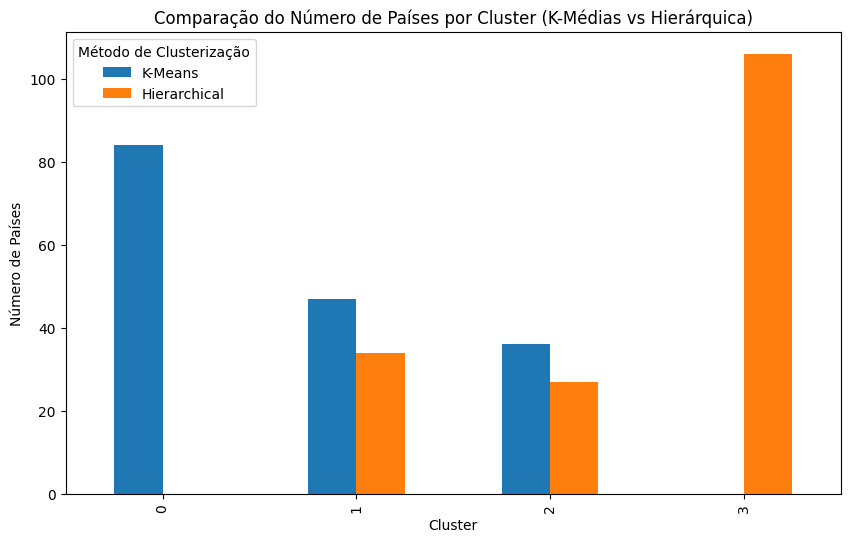

In [67]:
# Comparação dos clusters entre K-Médias e Clusterização Hierárquica
df_scaled['Cluster_Hierarchical'] = sch.fcluster(linkage_matrix, 3, criterion='maxclust')
df['Cluster_Hierarchical'] = df_scaled['Cluster_Hierarchical']

# Contagem de países em cada cluster para ambos os métodos
kmeans_counts = df['Cluster_KMeans'].value_counts().sort_index()
hierarchical_counts = df['Cluster_Hierarchical'].value_counts().sort_index()

comparison = pd.DataFrame({
    'K-Means': kmeans_counts,
    'Hierarchical': hierarchical_counts
})

# Gráfico de barras para comparar os clusters entre os métodos
comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Comparação do Número de Países por Cluster (K-Médias vs Hierárquica)')
plt.xlabel('Cluster')
plt.ylabel('Número de Países')
plt.legend(title='Método de Clusterização')
plt.show()


O gráfico acima, comparando o número de países em cada cluster entre os métodos revela:

* **K-Médias** distribui os países de maneira mais equilibrada entre os clusters 0, 1 e 2.
* **Clusterização Hierárquica** agrupa a maioria dos países em um único cluster (Cluster 3), sugerindo que muitos países têm características que os fazem parecer mais similares, de acordo com o método hierárquico.

Essa diferença pode ser explicada pela natureza dos algoritmos. O K-Médias força a criação de clusters de tamanhos mais uniformes, enquanto a Clusterização Hierárquica é mais sensível às similaridades globais, resultando em um agrupamento maior e menos diversificado para países com características próximas.

**Conclusão**

**K-Médias** é eficaz para dividir os países em três níveis distintos de desenvolvimento, com uma divisão mais equilibrada entre os clusters, enquanto a **Clusterização Hierárquica** oferece uma visão hierárquica que enfatiza a similaridade global entre os países, resultando em um cluster dominante e menos distinções entre grupos.

Ambas as técnicas identificam padrões relevantes, mas o K-Médias é mais útil para uma análise com clusters de tamanho similar, enquanto a Clusterização Hierárquica é útil para observar relações de similaridade em um nível mais granular.

## Parte 4 - Escolha de Algoritimos

#### 1. Escreva em tópicos as etapas do algoritmo de K-médias até sua convergência.

As etapas do algoritmo de K-Médias para encontrar os centróides dos clusters até a convergência são:

1. **Inicialização:** Seleciona aleatoriamente 𝐾 pontos como centróides iniciais.
2. **Atribuição de Pontos aos Clusters:** Cada ponto de dado é atribuído ao cluster com o centróide mais próximo, de acordo com uma métrica de distância (geralmente a distância euclidiana).
3. **Recomputação dos Centróides:** Calcula o novo centróide para cada cluster como a média de todos os pontos atribuídos a ele.
4. **Verificação de Convergência:** Compara os centróides atuais com os anteriores. Se o deslocamento dos centróides entre as iterações for menor que um valor mínimo predefinido ou se não houver mudanças significativas, o algoritmo é considerado convergente.
5. **Iteração até Convergência:** Repete as etapas 2 a 4 até que o critério de convergência seja atendido.

Ao final, o algoritmo termina com clusters formados e seus respectivos centróides.

#### Abaixo um exemplo em python:

In [91]:
# Dados aleatórios para fins de exemplo
np.random.seed(0)
dataset = np.random.rand(100, 2)  # 100 pontos de dados com 2 dimensões

# Número de clusters
num_clusters = 3
# Número máximo de iterações
max_iters = 100
# Critério de convergência (tolerância mínima para movimentação dos centróides)
convergence_threshold = 1e-4

# Passo 1: Inicializa aleatoriamente centróides a partir dos dados
initial_centroids = dataset[np.random.choice(range(dataset.shape[0]), num_clusters, replace=False)]

for iteration in range(max_iters):
    # Passo 2: Atribui cada ponto ao centróide mais próximo
    distances = np.array([np.linalg.norm(dataset - centroid, axis=1) for centroid in initial_centroids])
    cluster_assignments = np.argmin(distances, axis=0)

    # Armazena os centróides antigos para comparar deslocamento
    previous_centroids = initial_centroids.copy()

    # Passo 3: Recalcula o centróide de cada cluster como a média dos pontos do cluster
    for cluster_index in range(num_clusters):
        points_in_cluster = dataset[cluster_assignments == cluster_index]
        if len(points_in_cluster) > 0:  # Garante que o cluster não está vazio
            initial_centroids[cluster_index] = points_in_cluster.mean(axis=0)

    # Passo 4: Verifica a convergência (se o deslocamento dos centróides for menor que a tolerância)
    centroid_movements = np.linalg.norm(initial_centroids - previous_centroids, axis=1)
    if np.all(centroid_movements < convergence_threshold):
        print(f'Convergência atingida após {iteration + 1} iterações.')
        break


print("Centróides finais:", initial_centroids)
print("Labels dos clusters:", cluster_assignments)


Convergência atingida após 9 iterações.
Centróides finais: [[0.76167338 0.40765364]
 [0.27223715 0.21097997]
 [0.35217863 0.78488734]]
Labels dos clusters: [2 0 2 2 0 0 2 1 2 2 0 2 2 2 0 2 2 2 0 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0
 0 1 1 1 2 0 1 2 2 2 1 1 0 0 2 2 0 2 2 0 0 0 0 0 0 2 1 0 0 1 0 2 0 0 2 0 2
 2 2 2 2 0 1 0 2 0 1 0 1 1 0 2 0 2 0 0 2 0 1 2 0 1 1]


#### 2. O algoritmo de K-médias converge até encontrar os centróides que melhor descrevem os clusters encontrados (até o deslocamento entre as interações dos centróides ser mínimo). Lembrando que o centróide é o baricentro do cluster em questão e não representa, em via de regra, um dado existente na base. Refaça o algoritmo apresentado na questão 1 a fim de garantir que o cluster seja representado pelo dado mais próximo ao seu baricentro em todas as iterações do algoritmo.

In [92]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances

# Inicializa o número de clusters
K = 3
max_iterations = 100  # número máximo de iterações para evitar loops infinitos

# Passo 1: Inicializa aleatoriamente K medóides a partir dos dados
medoids = df_features.sample(K, random_state=0).values  # Seleciona aleatoriamente os pontos iniciais

for iteration in range(max_iterations):
    # Passo 2: Atribui cada ponto ao medóide mais próximo
    distances = pairwise_distances(df_features, medoids, metric='euclidean')
    labels = np.argmin(distances, axis=1)

    # Armazena os medóides antigos para comparar deslocamento
    old_medoids = medoids.copy()

    # Passo 3: Para cada cluster, encontra o ponto mais próximo ao centro que minimiza a distância total
    for k in range(K):
        cluster_points = df_features[labels == k]
        if len(cluster_points) > 0:  # Garante que o cluster não está vazio
            # Calcula a soma das distâncias entre pontos do cluster
            intra_cluster_distances = pairwise_distances(cluster_points, cluster_points, metric='euclidean')
            total_distances = intra_cluster_distances.sum(axis=1)
            medoids[k] = cluster_points.iloc[np.argmin(total_distances)].values

    # Passo 4: Verifica a convergência
    if np.all(old_medoids == medoids):
        print(f'Convergência atingida após {iteration + 1} iterações.')
        break

# Resultados finais
print("Medóides finais:", medoids)
print("Labels dos clusters:", labels)


Convergência atingida após 4 iterações.
Medóides finais: [[-0.5986385  -0.05887256  0.42149672  0.07497971 -0.09597625 -0.70792551
   0.69298003 -0.77384064  0.16613147]
 [ 0.906037   -0.42477331 -0.58266559 -0.04102478 -0.73280418  0.83671708
  -0.94238801  0.87592175 -0.63775406]
 [-0.68319878  0.9363775  -1.52840392 -0.6831925   3.02052649  0.32433487
   0.86215604 -0.48894192  1.39740611]]
Labels dos clusters: [1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 2 0 1 1 1 1 0 0 1 1 0 0 0 1
 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 0 0 0 0 0 1 1 1 2 1 1 0 0 1 1 0 0 2 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0
 0 1 1 2 2 1 0 0 0 1 0 0 2 0 0 1 0 2 1 0 0 1 2 0 0 1 1 0 0 1 0 1 0 0 0 1 1
 0 1 1 1 0 0 1 1 0 2 0 0 0 1 1 1 0 1 1]


#### 3. O algoritmo de K-médias é sensível a outliers nos dados. Explique.

O algoritmo de K-Médias é sensível a outliers porque ele usa a média dos pontos para calcular os centróides. Outliers, que são valores extremos, podem deslocar a posição dos centróides para regiões que não representam adequadamente a densidade da maioria dos dados no cluster. Isso pode fazer com que os centróides estejam longe da maior concentração de dados do cluster, impactando negativamente a qualidade dos clusters formados.



#### Por que o algoritmo de DBScan é mais robusto à presença de outliers?

O DBScan é mais robusto à presença de outliers porque ele utiliza uma abordagem baseada em densidade para formar clusters. Em vez de otimizar centróides, ele identifica regiões densas de pontos e agrupa apenas esses pontos, ignorando aqueles que estão isolados (ou seja, com baixa densidade de vizinhos). Esses pontos isolados são tratados como ruído ou outliers e não afetam a formação dos clusters principais. Assim, o DBScan consegue formar clusters de forma robusta sem ser influenciado por valores extremos ou dispersos.

### Experimentando com DBScan

Número de clusters formados (incluindo outliers):
-1     36
 0    111
 1     20
Name: Cluster_DBScan, dtype: int64


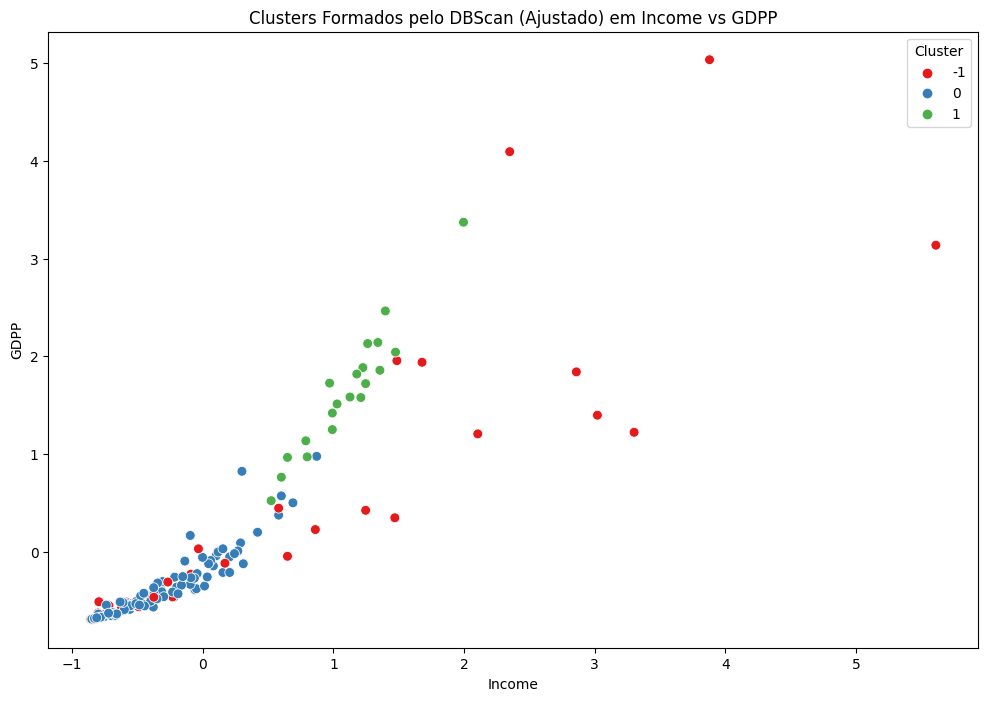

In [112]:
# Ajustar o valor de eps (Valores maiores tendem a gerar mais clusters)
eps_value = 1.5

# Ajustar o modelo DBScan
dbscan = DBSCAN(eps=eps_value, min_samples=5)
df_scaled['Cluster_DBScan'] = dbscan.fit_predict(df_scaled[variables])

# Conta o número de clusters formados (incluindo outliers)
clusters_dbscan = df_scaled['Cluster_DBScan'].value_counts().sort_index()
print("Número de clusters formados (incluindo outliers):")
print(clusters_dbscan)

# Visualização
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_scaled['income'], y=df_scaled['gdpp'], hue=df_scaled['Cluster_DBScan'], palette='Set1', s=50)
plt.title('Clusters Formados pelo DBScan (Ajustado) em Income vs GDPP')
plt.xlabel('Income')
plt.ylabel('GDPP')
plt.legend(title='Cluster', loc='best')
plt.show()


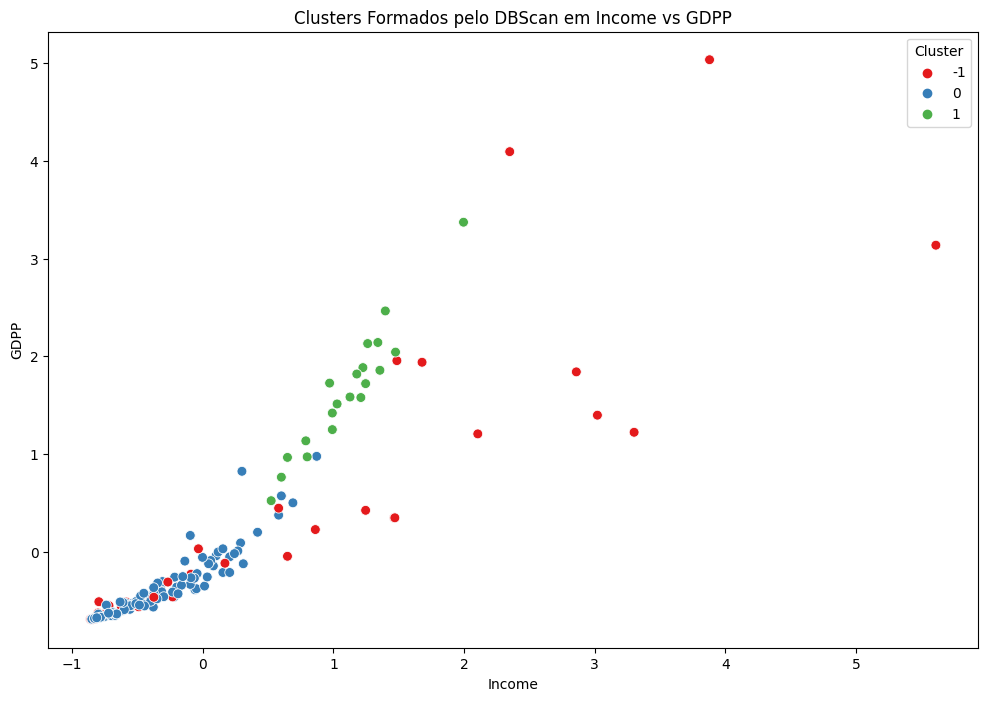

In [113]:
# Visualizar os clusters formados (excluindo outliers)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_scaled['income'], y=df_scaled['gdpp'], hue=df_scaled['Cluster_DBScan'], palette='Set1', s=50)
plt.title('Clusters Formados pelo DBScan em Income vs GDPP')
plt.xlabel('Income')
plt.ylabel('GDPP')
plt.legend(title='Cluster', loc='best')
plt.show()
